In [ ]:
import os
import pandas as pd
import joblib
import time
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths
SPLITS_DIR = "/content/drive/My Drive/FDM Project Files/splits"
GBM_DIR = "/content/drive/My Drive/FDM Project Files/models/gradiant_boosting"
RESULTS_PATH_GLOBAL = "/content/drive/My Drive/FDM Project Files/models/results.csv"
RESULTS_PATH_LOCAL = os.path.join(GBM_DIR, "gbm_results.csv")

In [ ]:
# Load validation data
X_val = pd.read_csv(os.path.join(SPLITS_DIR, "X_val.csv"))
y_val = pd.read_csv(os.path.join(SPLITS_DIR, "y_val.csv")).squeeze()

# Load model
model_path = os.path.join(GBM_DIR, "gbm_model.pkl")
gbm = joblib.load(model_path)

In [ ]:
# Load column order from training
with open(os.path.join(GBM_DIR, "gbm_columns.json"), "r") as f:
    train_columns = json.load(f)

# Apply one-hot encoding to validation set
X_val = pd.get_dummies(X_val, columns=['Overtime'], drop_first=True)

# Align columns with training
X_val = X_val.reindex(columns=train_columns, fill_value=0)

In [ ]:
# Load training metadata
with open(os.path.join(GBM_DIR, "gbm_meta.json"), "r") as f:
    meta = json.load(f)
train_time = meta["Train_Time_sec"]

# Validation inference and timing
start_test = time.time()
y_val_pred = gbm.predict(X_val)
y_val_proba = gbm.predict_proba(X_val)[:, 1]
end_test = time.time()
test_time = round(end_test - start_test, 3)

print(f" Inference time: {test_time} seconds")

 Inference time: 0.11 seconds


In [ ]:
# Collect metrics
results = {
    "Model": "GradientBoosting",
    "Accuracy": accuracy_score(y_val, y_val_pred),
    "Precision": precision_score(y_val, y_val_pred, pos_label='Left'),
    "Recall": recall_score(y_val, y_val_pred, pos_label='Left'),
    "F1": f1_score(y_val, y_val_pred, pos_label='Left'),
    "ROC_AUC": roc_auc_score(y_val, y_val_proba),
    "Train_Time_sec": train_time,  # from training script
    "Test_Time_sec": test_time,
    "Interpretability": "Medium (feature importance, PDPs)"
}

print("\n Validation Results for GBM:")
for k, v in results.items():
    print(f"{k}: {v}")


 Validation Results for GBM:
Model: GradientBoosting
Accuracy: 0.7613255033557047
Precision: 0.752098589033756
Recall: 0.7429428369795342
F1: 0.747492677731428
ROC_AUC: 0.8496695877361587
Train_Time_sec: 21.54
Test_Time_sec: 0.11
Interpretability: Medium (feature importance, PDPs)


/tmp/ipython-input-2140615952.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(15), palette="mako")


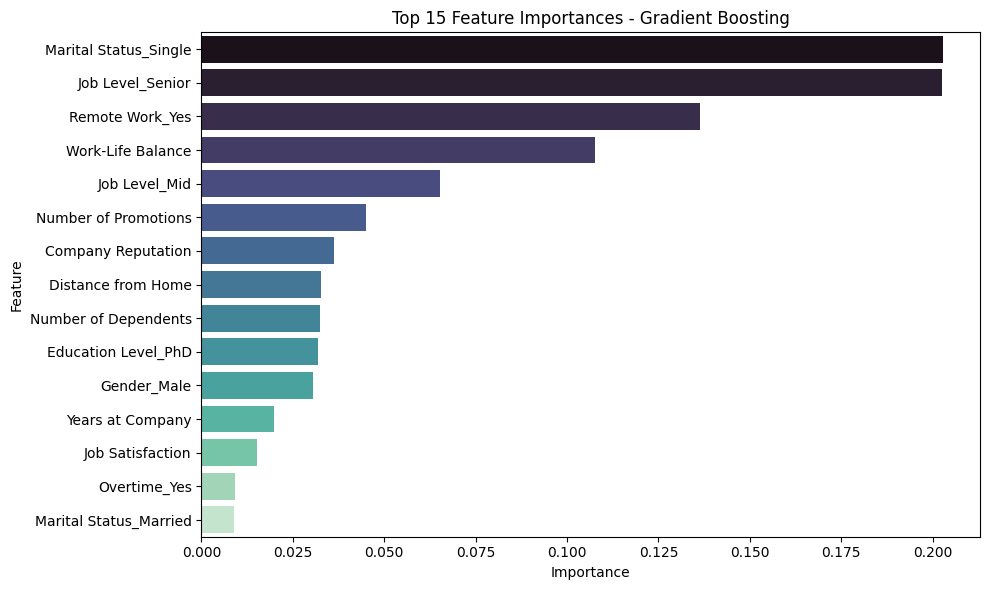

✅ Feature importance plot saved to: /content/drive/My Drive/FDM Project Files/models/gradiant_boosting/gbm_feature_importance.png


In [ ]:
# ----------------------------
# 🎨 Feature Importance Plot (GBM)
# ----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from GBM
importances = gbm.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": train_columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(15), palette="mako")
plt.title("Top 15 Feature Importances - Gradient Boosting")
plt.tight_layout()

# Save the plot
plot_path = os.path.join(GBM_DIR, "gbm_feature_importance.png")
plt.savefig(plot_path)
plt.show()

print(" Feature importance plot saved to:", plot_path)


In [ ]:
# Save locally
df_local = pd.DataFrame([results])
df_local.to_csv(RESULTS_PATH_LOCAL, index=False)
print(" Local results saved to:", RESULTS_PATH_LOCAL)

# Save globally
if os.path.exists(RESULTS_PATH_GLOBAL):
    old = pd.read_csv(RESULTS_PATH_GLOBAL)
    df_global = pd.concat([old, df_local], ignore_index=True)
else:
    df_global = df_local

df_global.to_csv(RESULTS_PATH_GLOBAL, index=False)
print(" Global results updated at:", RESULTS_PATH_GLOBAL)

 Local results saved to: /content/drive/My Drive/FDM Project Files/models/gradiant_boosting/gbm_results.csv
 Global results updated at: /content/drive/My Drive/FDM Project Files/models/results.csv
